In [0]:
# Install packages
!pip install -q --upgrade tf-nightly-gpu-2.0-preview
!pip install -q --upgrade tfp-nightly

# Packages
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.math import random_rademacher

np.random.seed(111)
tf.random.set_seed(111)

In [0]:
def softplus(data):
    return np.log(np.exp(data) + 1)

# Dummy regression
N_train = 100000
N_val = 10000
D = 8
w = np.random.randn(D, 1)
x_train = np.random.randn(N_train, D)
y_train = softplus(x_train) @ w + 0.1*np.random.randn(N_train, 1)
x_val = np.random.randn(N_val, D)
y_val = softplus(x_val) @ w + 0.1*np.random.randn(N_val, 1)

def zscore(data):
    return ((data-np.mean(data, axis=0))/np.std(data, axis=0)).astype('float32')

x_train = zscore(x_train)
y_train = zscore(y_train)
x_val = zscore(x_val)
y_val = zscore(y_val)

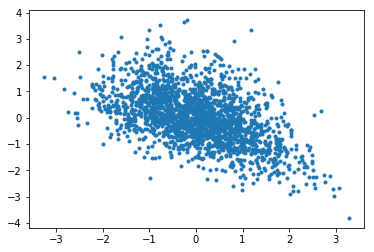

In [3]:
plt.plot(x_train[:2000, 0], y_train[:2000], '.')

In [4]:
# Make a TensorFlow Dataset from training data
batch_size = 1024
data_train = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

# Make a TensorFlow Dataset from validation data
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)

W0705 04:25:36.699215 140275039778688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/data/util/random_seed.py:58: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
class BayesianDenseLayer(tf.keras.Model):
    
    def __init__(self, d_in, d_out, name=None):
        
        # Xavier initializer
        def xavier(shape):
            return tf.random.truncated_normal(
                shape, 
                mean=0.0,
                stddev=np.sqrt(2/sum(shape)))
        
        super(BayesianDenseLayer, self).__init__(name=name)
        
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out]), name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out]), name='b_std')
        
    
    def call(self, x, sampling=True):
        
        if sampling:
            weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
            bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
            return x @ weight.sample() + bias.sample()
            
        else:
            return x @ self.w_loc + self.b_loc
    
    
    @property
    def losses(self):
        # TODO: maybe need to adjust the priors based on xavier scheme?
        weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
        bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(bias, prior)))

In [0]:
class BayesianDenseNetwork(tf.keras.Model):
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseNetwork, self).__init__(name=name)
        
        self.steps = []
        self.acts = []
        for i in range(len(dims)-1):
            self.steps += [BayesianDenseLayer(dims[i], dims[i+1])]
            self.acts += [tf.nn.relu]
            
        self.acts[-1] = lambda x: x
        
    
    def call(self, x, sampling=True):
        
        for i in range(len(self.steps)):
            x = self.steps[i](x, sampling=sampling)
            x = self.acts[i](x)
            
        return x
    
    
    @property
    def losses(self):
        return tf.reduce_sum([s.losses for s in self.steps])

In [0]:
model = BayesianDenseNetwork([D, 10, 1])

In [8]:

optimizer = tf.keras.optimizers.Adam(lr=1e-2)

N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        preds = model(x_data)
        ll = tf.reduce_sum(tfd.Normal(preds, 1).log_prob(y_data))
        kl_loss = model.losses
        elbo_loss = kl_loss/N - ll
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
# Fit the model
EPOCHS = 200
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        preds = model(x_data, sampling=False)
        mae = mean_absolute_error(preds, y_data)
        print('Epoch {}  \tMAE {}'.format(epoch, mae))

W0705 04:25:38.063953 140275039778688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Epoch 0  	MAE 1.0424357652664185
Epoch 1  	MAE 0.9696404337882996
Epoch 2  	MAE 0.8906635642051697
Epoch 3  	MAE 0.8103258013725281
Epoch 4  	MAE 0.7411847710609436
Epoch 5  	MAE 0.6629216074943542
Epoch 6  	MAE 0.5523104667663574
Epoch 7  	MAE 0.5242503881454468
Epoch 8  	MAE 0.47741225361824036
Epoch 9  	MAE 0.3954087197780609
Epoch 10  	MAE 0.3499319553375244
Epoch 11  	MAE 0.3135261833667755
Epoch 12  	MAE 0.3035295903682709
Epoch 13  	MAE 0.2779151201248169
Epoch 14  	MAE 0.2570693790912628
Epoch 15  	MAE 0.24121713638305664
Epoch 16  	MAE 0.2450021505355835
Epoch 17  	MAE 0.24825644493103027
Epoch 18  	MAE 0.24454589188098907
Epoch 19  	MAE 0.21617788076400757
Epoch 20  	MAE 0.24284014105796814
Epoch 21  	MAE 0.2176610380411148
Epoch 22  	MAE 0.22272160649299622
Epoch 23  	MAE 0.18698592483997345
Epoch 24  	MAE 0.18460243940353394
Epoch 25  	MAE 0.18194003403186798
Epoch 26  	MAE 0.18077442049980164
Epoch 27  	MAE 0.17389635741710663
Epoch 28  	MAE 0.17152372002601624
Epoch 29  	